In [2]:
import sys
import os
sys.path.append("..") 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.preprocessing import Preprocessor
from src.lstm_forecasting import LSTMForecaster, LSTMTimeSeries
from sklearn.metrics import mean_squared_error
from preprocess import *
from add_features import *
from models import *
# Pour ne pas afficher de warnings inutiles
import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

In [3]:
champs_elysees_df = pd.read_csv('../data/traffic/champs_elysees.csv', sep=";")
convention_df = pd.read_csv('../data/traffic/convention.csv', sep=";")
# sts_peres_df = pd.read_csv('../data/traffic/sts_peres.csv', sep=";")

weather_df = pd.read_csv('../data/weather/weather_paris.csv')
holidays_df = pd.read_csv('../data/events/french_holidays.csv', sep=";")
football_matches_df = pd.read_csv('../data/events/football_matches_2024_2025.csv')

In [4]:
def treat_nan_convention(convention_df):
    # Keep only data for the specific arc
    convention_df = convention_df.loc[convention_df['Identifiant arc'] == 5671, :]

    # Convert datetime column to timezone-aware timestamps
    convention_df['Date et heure de comptage'] = pd.to_datetime(
        convention_df['Date et heure de comptage'], errors='coerce', utc=True
    )

    # Sort chronologically
    convention_df = convention_df.sort_values(by=['Date et heure de comptage'])

    # Define date ranges (full days)
    start_1 = pd.Timestamp('2024-12-06T00:00:00+01:00')  # start of first day
    end_1 = pd.Timestamp('2025-02-11T23:59:59+01:00')    # end of last day
    cutoff_2 = pd.Timestamp('2025-05-21T00:00:00+01:00') # start of second period

    # Filter data for both periods (full days)
    df_period1 = convention_df[
        (convention_df['Date et heure de comptage'] >= start_1) &
        (convention_df['Date et heure de comptage'] <= end_1)
    ]
    df_period2 = convention_df[
        convention_df['Date et heure de comptage'] >= cutoff_2
    ]

    # Concatenate both periods
    convention_df = pd.concat([df_period1, df_period2]).reset_index(drop=True)

    return convention_df


# Apply the function
convention_df = treat_nan_convention(convention_df)


In [7]:
# champs_elysees_df.isna().sum()/champs_elysees_df["Identifiant arc"].count()

In [8]:
preprocessor = Preprocessor(df=champs_elysees_df)

# On applique ton pipeline de preprocessing
df_processed = preprocessor.fit_transform(holidays_df=holidays_df, weather_df=weather_df, sports_df=football_matches_df)

print("Preprocessed Data :", df_processed.shape)
display(df_processed.sample(5))


Preprocessed Data : (8627, 45)


,Identifiant arc,Libelle,Débit horaire,Taux d'occupation,Etat trafic,Identifiant noeud amont,Libelle noeud amont,Identifiant noeud aval,Libelle noeud aval,Etat arc,...,wind_speed_10m (km/h),weather_code (wmo code),surface_pressure (hPa),cloud_cover (%),apparent_temperature (°C),rain (mm),sport_event_name,is_sport_event,Débit horaire_outlier_iqr,Taux d'occupation_outlier_iqr
Date et heure de comptage,,,,,,,,,,,,,,,,,,,,,
2025-08-26 17:00:00,4264,AV_Champs_Elysees,799.000000,24.81000,Pré-saturé,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Ouvert,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
2024-11-07 09:00:00,4264,AV_Champs_Elysees,1045.000000,12.68222,Fluide,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Invalide,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
2025-07-17 15:00:00,4264,AV_Champs_Elysees,999.000000,30.01889,Saturé,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Ouvert,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
2024-10-31 18:00:00,4264,AV_Champs_Elysees,448.470588,5.55155,Inconnu,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Invalide,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
2024-10-28 09:00:00,4264,AV_Champs_Elysees,967.000000,10.73056,Fluide,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Invalide,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False


In [5]:
df_champs_lstm=pipeline(convention_df, window=3, fill_hours=False)
df_champs_xgb = pipeline(convention_df,window=3,fill_hours=False)

# LSTM Forecasting

In [ ]:
forecaster = LSTMForecaster(
    seq_length= 168,  # 7 historical days
    pred_length=72,  # prediction 72h in advance
    lstm_units=64,
    dropout=0.2,
    use_weather=False,
    use_holidays=False,
    use_sport=False,
    use_outliers=False
)

# Preparation of sequences
X_train, X_test, y_train, y_test = forecaster.prepare_data(df_lisse)

# Training
history = forecaster.train(
    X_train, y_train,
    X_test, y_test,
    epochs=10, batch_size=32
)
y_test_inv, y_pred_inv = forecaster.evaluate(X_test, y_test)

# Visualisation on the first 72 hours
forecaster.plot_predictions(y_test_inv, y_pred_inv, n_plot=150)

In [ ]:
# Concaténer train + test pour la CV (on prend tout)
X_all = np.concatenate([X_train, X_test], axis=0)
y_all = np.concatenate([y_train, y_test], axis=0)

forecaster.time_series_cv(X_all, y_all, n_splits=5, epochs=5, batch_size=32)

# XGBoost model

In [6]:
from src.xgb_forecasting import XGBoostModel

Train set: (4944, 25), Test set: (72, 25) (72 hours)
Débit horaire : RMSE = 48.51, Mean = 389.56, Relative Error = 12.45%
Taux d'occupation : RMSE = 1.20, Mean = 3.49, Relative Error = 34.37%


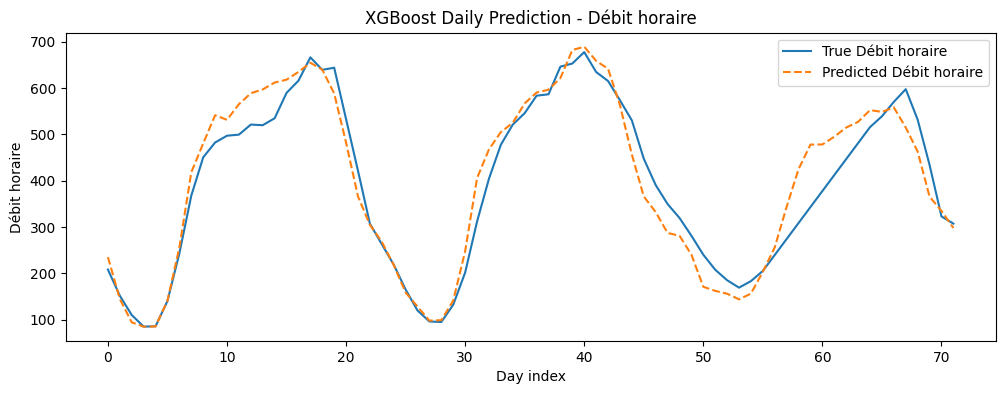

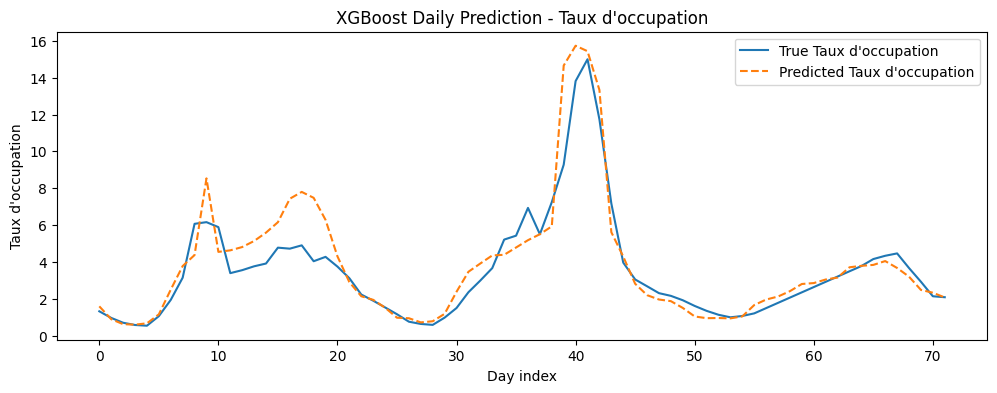

In [7]:
targets = ['Débit horaire', "Taux d'occupation"]
features_xgb = ['is_holiday',
                'is_sport_event',
                'temperature_2m (°C)','wind_speed_10m (km/h)',
                'precipitation (mm)','cloud_cover (%)'] 

features_xgb = [
        'hour_sin', 'hour_cos', 
        'weekday_sin', 'weekday_cos', 
        'month_sin', 'month_cos', 
        'dayofyear_sin', 'dayofyear_cos',
        'is_weekend', 'is_holiday',
        'Vacances Scolaires Paris', 
        'temperature_2m (°C)', 'wind_speed_10m (km/h)',
        'precipitation (mm)', 'cloud_cover (%)',
        'Débit horaire_outlier_high', 'Débit horaire_outlier_low', 'Débit horaire_special_event',
        "Taux d'occupation_outlier_high", "Taux d'occupation_outlier_low", "Taux d'occupation_special_event"]

df_xgb = df_champs_xgb.copy()

# Lags à créer (en heures)
lags_hours = [72,168]  # 1h, 3h, 1 jour, 2 jours, 1 semaine

for target in targets:
    for lag in lags_hours:
        col_name = f"{target}_lag_{lag}h"
        df_xgb[col_name] = df_xgb[target].shift(lag)
        features_xgb.append(col_name)

# Supprimer les lignes contenant des NaN générés par les lags
df_xgb = df_xgb.dropna(subset=[f"{t}_lag_{lag}h" for t in targets for lag in lags_hours] + targets).copy()


xgb_model = XGBoostModel(df_xgb, features_xgb, targets)
xgb_model.prepare_data(horizon=72)

xgb_model.fit()

# Prediction on the test set
y_test, y_pred = xgb_model.evaluate()

# Plot
for i, target in enumerate(targets):
    plt.figure(figsize=(12,4))
    plt.plot(y_test[:, i], label=f"True {target}")
    plt.plot(y_pred[:, i], '--', label=f"Predicted {target}")
    plt.title(f"XGBoost Daily Prediction - {target}")
    plt.xlabel("Day index")
    plt.ylabel(target)
    plt.legend()
    plt.show()



In [8]:
cv_results = xgb_model.cross_validate(n_splits=5)

Débit horaire : CV RMSE mean = 106.33, std = 52.07 | MAE mean = 84.46, std = 42.53 | 
 MAPE mean = 34.63%, std = 20.63% | RMSE/mean = 26.72%, std = 11.18
Taux d'occupation : CV RMSE mean = 1.71, std = 0.75 | MAE mean = 1.11, std = 0.47 | 
 MAPE mean = 53.59%, std = 38.68% | RMSE/mean = 46.62%, std = 13.01


# Hybrid LSTM + XGBoost model 

In [10]:
## Hybrid LSTM + XGBoost model

### LSTM for short-term patterns
lstm_model = LSTMForecaster(
    seq_length= 168,  # 7 historical days
    pred_length=72,  # prediction 72h in advance
    lstm_units=64,
    dropout=0.2,
    use_weather=False,
    use_holidays=False,
    use_sport=False
)

# Preparation of sequences
X_train, X_test, y_train, y_test = lstm_model.prepare_data(df_processed)

# Training
history = lstm_model.train(
    X_train, y_train,
    X_test, y_test,
    epochs=5, batch_size=32
)

# Predictions LSTM
y_test_inv, y_pred_inv = lstm_model.evaluate(X_test, y_test)

### XGBoost for long-term patterns
# Compute daily averages
# daily_df = df_processed.groupby('date').agg({
#     'Débit horaire':'mean',
#     "Taux d'occupation":'mean',
#     'is_holiday':'first',
#     'is_sport_event':'first',
#     'temperature_2m (°C)':'mean',
#     'wind_speed_10m (km/h)':'mean',
#     'precipitation (mm)':'mean',
#     'cloud_cover (%)':'mean'
# }).reset_index()

# Features for XGBoost
features_xgb = ['is_holiday','is_sport_event','temperature_2m (°C)',
                'wind_speed_10m (km/h)','precipitation (mm)','cloud_cover (%)']


df_xgb = df_processed.copy()
df_xgb['lag_1d'] = df_xgb['Débit horaire'].shift(24)
df_xgb['lag_1w'] = df_xgb['Débit horaire'].shift(24*7)

features_xgb += ['lag_1d', 'lag_1w']


# Instanciate XGBoost
xgb_model = XGBoostModel(df_xgb, features_xgb, lstm_model.targets)
xgb_model.prepare_data(horizon=72)
xgb_model.fit()

# Predictions XGBoost (long-term)
y_pred_xgb = xgb_model.predict()


Epoch 1/5
210/210 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - loss: 0.0234 - val_loss: 0.0131
Epoch 2/5
210/210 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - loss: 0.0127 - val_loss: 0.0106
Epoch 3/5
210/210 ━━━━━━━━━━━━━━━━━━━━ 12s 59ms/step - loss: 0.0117 - val_loss: 0.0105
Epoch 4/5
210/210 ━━━━━━━━━━━━━━━━━━━━ 12s 58ms/step - loss: 0.0114 - val_loss: 0.0110
Epoch 5/5
210/210 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - loss: 0.0111 - val_loss: 0.0110
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
Débit horaire : RMSE = 216.27, Mean = 738.55, Relative error = 29.28%
Taux d'occupation : RMSE = 8.23, Mean = 16.53, Relative error = 49.81%
Train set: (1417, 8), Test set: (72, 8) (72 hours)


In [11]:
# Combine LSTM and XGBoost predictions
y_test_inv, y_pred_lstm_array = lstm_model.evaluate(X_test, y_test)
print("LSTM Prediction Array Shape :", y_pred_lstm_array.shape)
y_pred_lstm_hourly = y_pred_lstm_array[-1, :, :]

alpha = 0.3
y_pred_final = alpha * y_pred_lstm_hourly + (1-alpha) * y_pred_xgb
print("Final Prediction Shape :", y_pred_final.shape)

y_true = y_test_inv[-1, :, :]  # real 72h for the last batch of LSTM
y_pred = y_pred_final           # 72h combined LSTM + XGBoost

for i, target in enumerate(lstm_model.targets):
    rmse = np.sqrt(np.mean((y_true[:, i] - y_pred[:, i])**2))
    mean_val = np.mean(y_true[:, i])
    rel_error = 100 * rmse / mean_val
    print(f"{target} : RMSE = {rmse:.2f}, Mean = {mean_val:.2f}, Relative Error = {rel_error:.2f}%")

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Débit horaire : RMSE = 216.27, Mean = 738.55, Relative error = 29.28%
Taux d'occupation : RMSE = 8.23, Mean = 16.53, Relative error = 49.81%
LSTM Prediction Array Shape : (1678, 72, 2)
Final Prediction Shape : (72, 2)
Débit horaire : RMSE = 265.06, Mean = 772.65, Relative Error = 34.31%
Taux d'occupation : RMSE = 9.53, Mean = 17.08, Relative Error = 55.82%


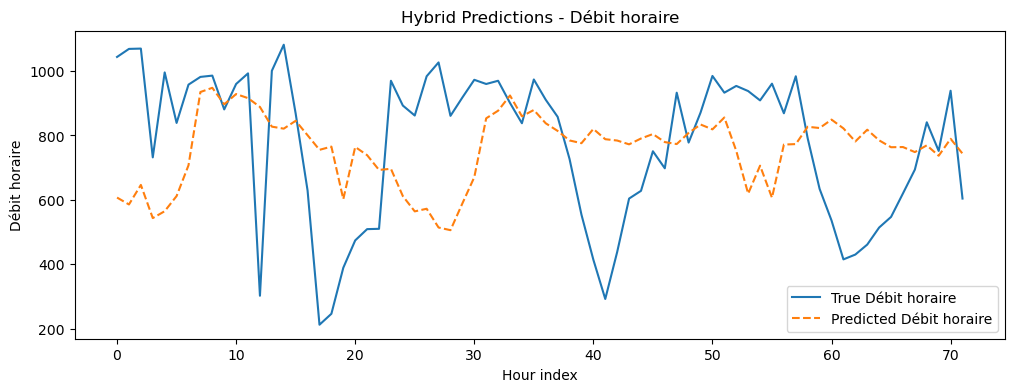

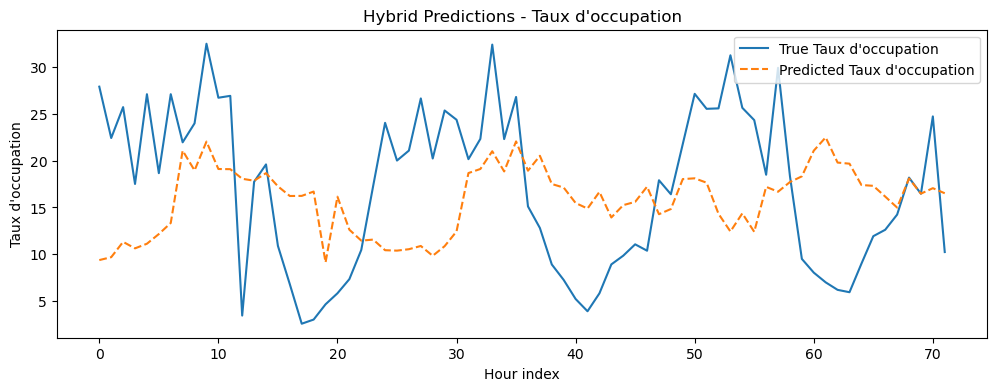

In [12]:
# Plot
for i, target in enumerate(targets):
    plt.figure(figsize=(12,4))
    plt.plot(y_test_inv[-1, :, :][:, i], label=f"True {target}")
    plt.plot(y_pred_final[:, i], '--', label=f"Predicted {target}")
    plt.title(f"Hybrid Predictions - {target}")
    plt.xlabel("Hour index")
    plt.ylabel(target)
    plt.legend()
    plt.show()

In [9]:
features = [
    'hour_sin', 'hour_cos', 
    'weekday_sin', 'weekday_cos', 
    'month_sin', 'month_cos', 
    'dayofyear_sin', 'dayofyear_cos',
    'is_weekend', 'is_holiday',
    'Vacances Scolaires Paris', 
    'temperature_2m (°C)', 'wind_speed_10m (km/h)',
    'precipitation (mm)', 'cloud_cover (%)',
    'Débit horaire_outlier_high', 'Débit horaire_outlier_low', 'Débit horaire_special_event',
    "Taux d'occupation_outlier_high", "Taux d'occupation_outlier_low", "Taux d'occupation_special_event"
]

targets = ['Débit horaire', "Taux d'occupation"]

features = [
        'hour_sin', 'hour_cos', 
        'weekday_sin', 'weekday_cos', 
        'month_sin', 'month_cos', 
        'dayofyear_sin', 'dayofyear_cos',
        'is_weekend', 'is_holiday',
        'Vacances Scolaires Paris', 
        'temperature_2m (°C)', 'wind_speed_10m (km/h)',
        'precipitation (mm)', 'cloud_cover (%)',
        'Débit horaire_outlier_high', 'Débit horaire_outlier_low', 'Débit horaire_special_event',
        "Taux d'occupation_outlier_high", "Taux d'occupation_outlier_low", "Taux d'occupation_special_event"]


In [10]:
final_eval_size = 72
seq_length = 168

# On garde les 168h avant la période finale pour le contexte
context_start = -(seq_length + final_eval_size)
context_end = -final_eval_size

train_val_df = df_champs_lstm.iloc[:-final_eval_size].copy()   # tout ce qui est AVANT le contexte
#context_df = df_champs.iloc[context_start:context_end].copy()  # les 168h de contexte
final_eval_df = df_champs_lstm.iloc[-final_eval_size:].copy()       # les 72h à prédire

print(f"Train: {train_val_df.shape},  Eval: {final_eval_df.shape}")

lstm_model = LSTMTimeSeries(
    features=features,
    targets=targets,
    seq_length=seq_length,
    pred_length=final_eval_size
)

Train: (5112, 53),  Eval: (72, 53)


In [25]:
df_champs_orig=pipeline(convention_df, window=0, fill_hours=True)
df_or = df_champs_orig.iloc[:-final_eval_size].copy()
lstm_model.cross_validate(train_val_df,df_or,epochs=30,batch_size=32)

3661
3950
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step

===== Fold 1 =====
Débit horaire             RMSE: 193.77, MEAN: 533.62, MAPE: 48.64%, RMSE/mean: 36.31%
Taux d'occupation         RMSE: 3.01, MEAN: 5.14, MAPE: 76.20%, RMSE/mean: 58.47%
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step

===== Fold 2 =====
Débit horaire             RMSE: 202.91, MEAN: 302.58, MAPE: 99.46%, RMSE/mean: 67.06%
Taux d'occupation         RMSE: 2.82, MEAN: 2.10, MAPE: 178.70%, RMSE/mean: 134.16%
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step

===== Fold 3 =====
Débit horaire             RMSE: 147.15, MEAN: 322.02, MAPE: 43.48%, RMSE/mean: 45.69%
Taux d'occupation         RMSE: 1.72, MEAN: 2.42, MAPE: 64.58%, RMSE/mean: 70.92%
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step

===== Fold 4 =====
Débit horaire             RMSE: 83.22, MEAN: 415.59, MAPE: 18.91%, RMSE/mean: 20.02%
Taux d'occupation         RMSE: 1.79, MEAN: 3.60, MAPE: 33.00%, RMSE/mean: 49.57%
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step

===== Fold 5 =====
Débit horaire    

In [ ]:
lstm_model.train_final(train_val_df, epochs=30, batch_size=32)

Epoch 1/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 0.5451 - mae: 0.5072 - mape: 223.6909
Epoch 2/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - loss: 0.3219 - mae: 0.3718 - mape: 218.5766
Epoch 3/30
 20/153 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - loss: 0.3002 - mae: 0.3543 - mape: 190.1396

In [ ]:
y_pred = lstm_model.predict(train_val_df[-168:])  # entrée : les 168 dernières heures avant la période finale

print("\n📊 Évaluation finale par target :")
for i, target_name in enumerate(targets):
    y_true_i = final_eval_df[targets[i]].values
    y_pred_i = y_pred[:, i]
    metrics = LSTMTimeSeries.evaluate_metrics(y_true_i, y_pred_i, target_name=target_name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step

📊 Évaluation finale par target :
Débit horaire             RMSE: 96.65, MEAN: 389.56, MAPE: 21.92%, RMSE/mean: 24.81%
Taux d'occupation         RMSE: 3.09, MEAN: 3.49, MAPE: 74.48%, RMSE/mean: 88.63%


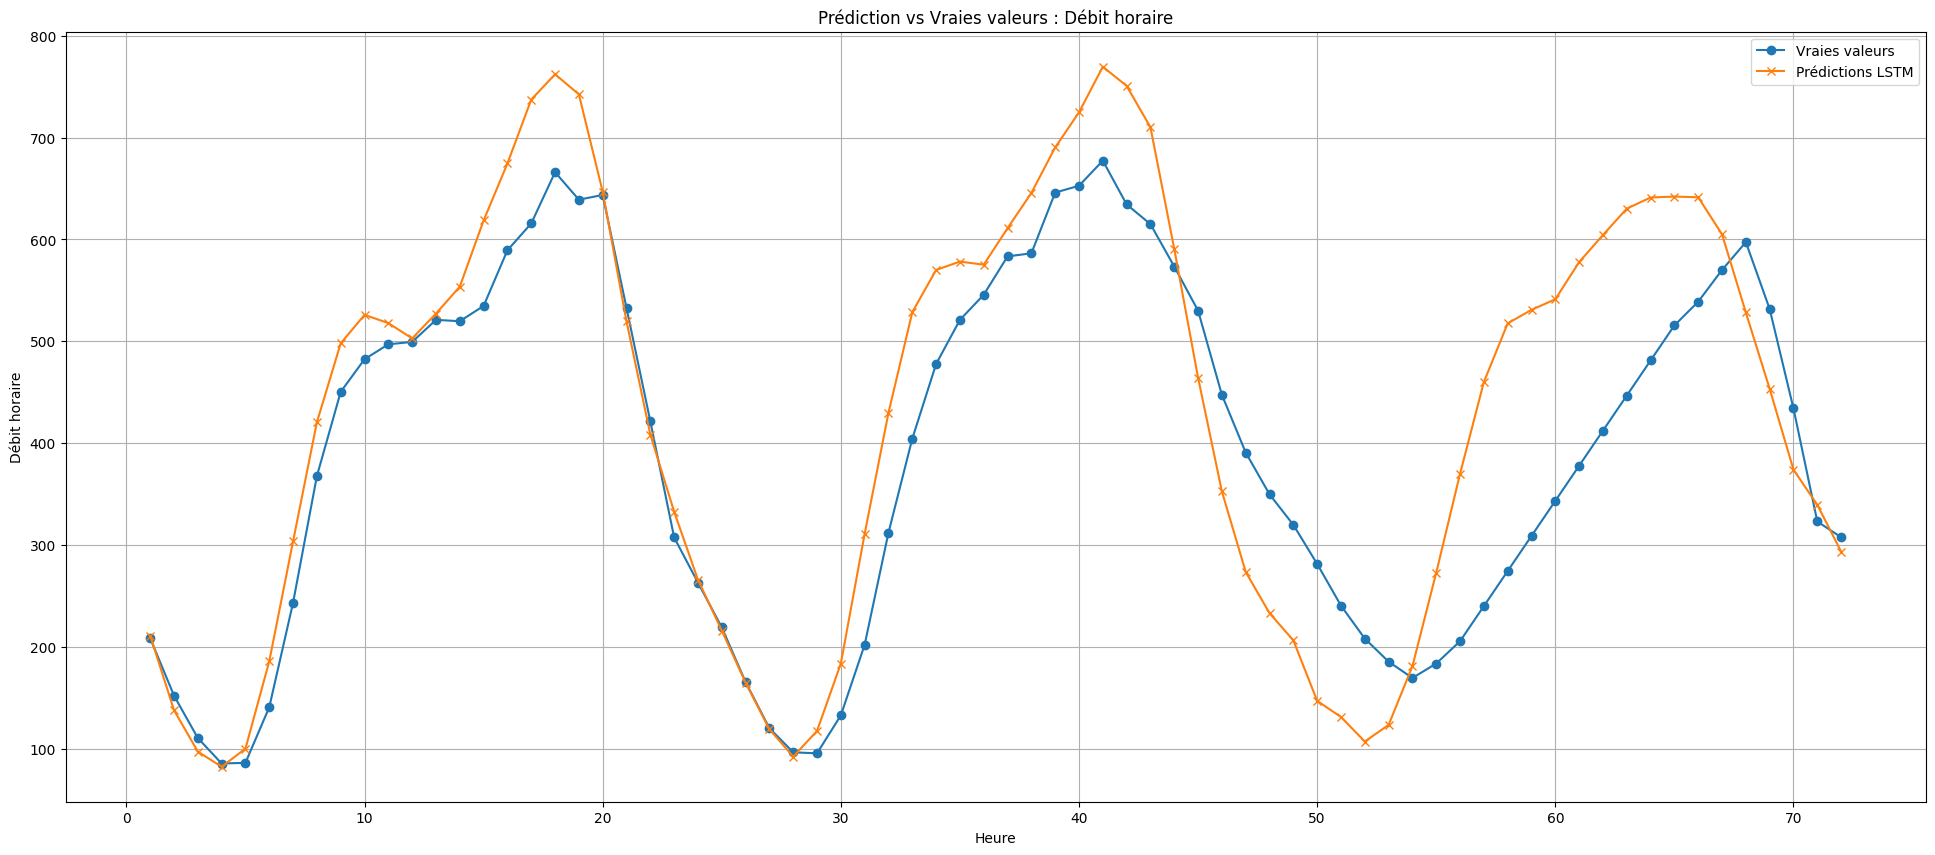

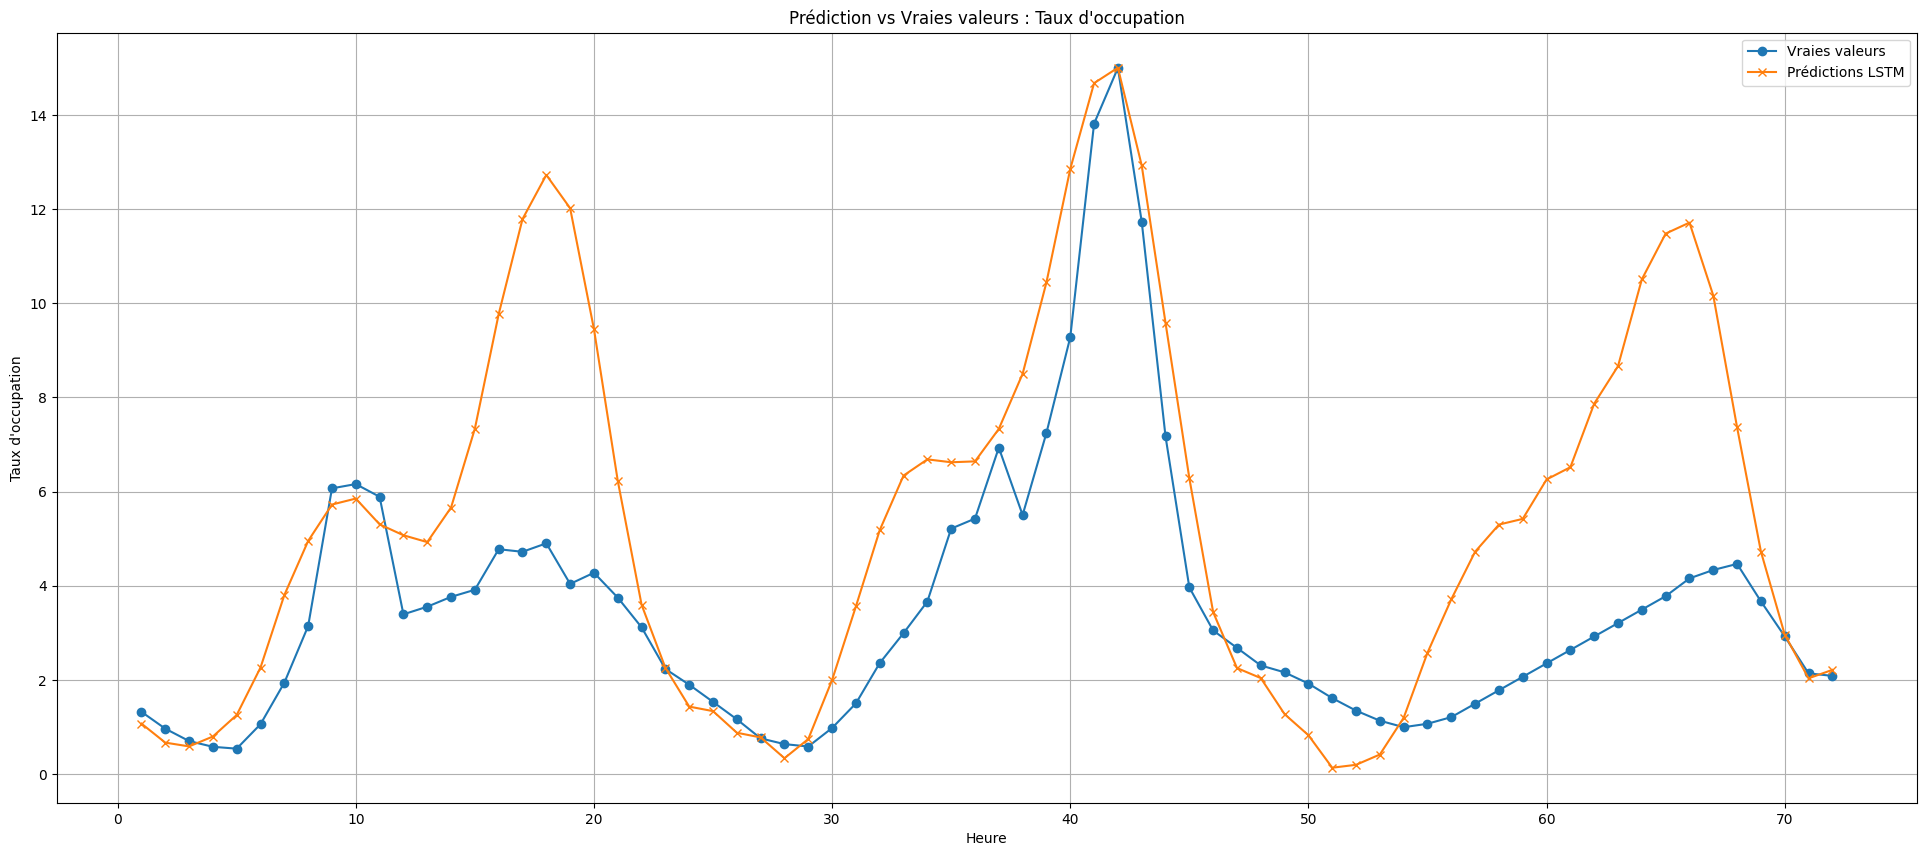

In [ ]:
hours = np.arange(1, 73)
for i, target in enumerate(targets):
    plt.figure(figsize=(24,10))
    plt.plot(hours, final_eval_df[targets[i]].values, marker='o', label='Vraies valeurs')
    plt.plot(hours, y_pred[:, i], marker='x', label='Prédictions LSTM')
    plt.title(f'Prédiction vs Vraies valeurs : {target}')
    plt.xlabel('Heure')
    plt.ylabel(target)
    plt.grid(True)
    plt.legend()
    plt.show()


In [ ]:
df_champs_orig=pipeline(convention_df, window=0, fill_hours=True)
df_champs_orig_last = df_champs_orig.iloc[-72:,:]
print("\n📊 Évaluation finale par target (sans fuite de données) :")
for i, target_name in enumerate(targets):
    y_true_i = df_champs_orig_last[targets[i]].values
    y_pred_i = y_pred[:, i]
    metrics = LSTMTimeSeries.evaluate_metrics(y_true_i, y_pred_i, target_name=target_name)

3661
3950

📊 Évaluation finale par target (sans fuite de données) :
Débit horaire             RMSE: 100.95, MEAN: 389.14, MAPE: 24.07%, RMSE/mean: 25.94%
Taux d'occupation         RMSE: 3.29, MEAN: 3.49, MAPE: 83.62%, RMSE/mean: 94.39%


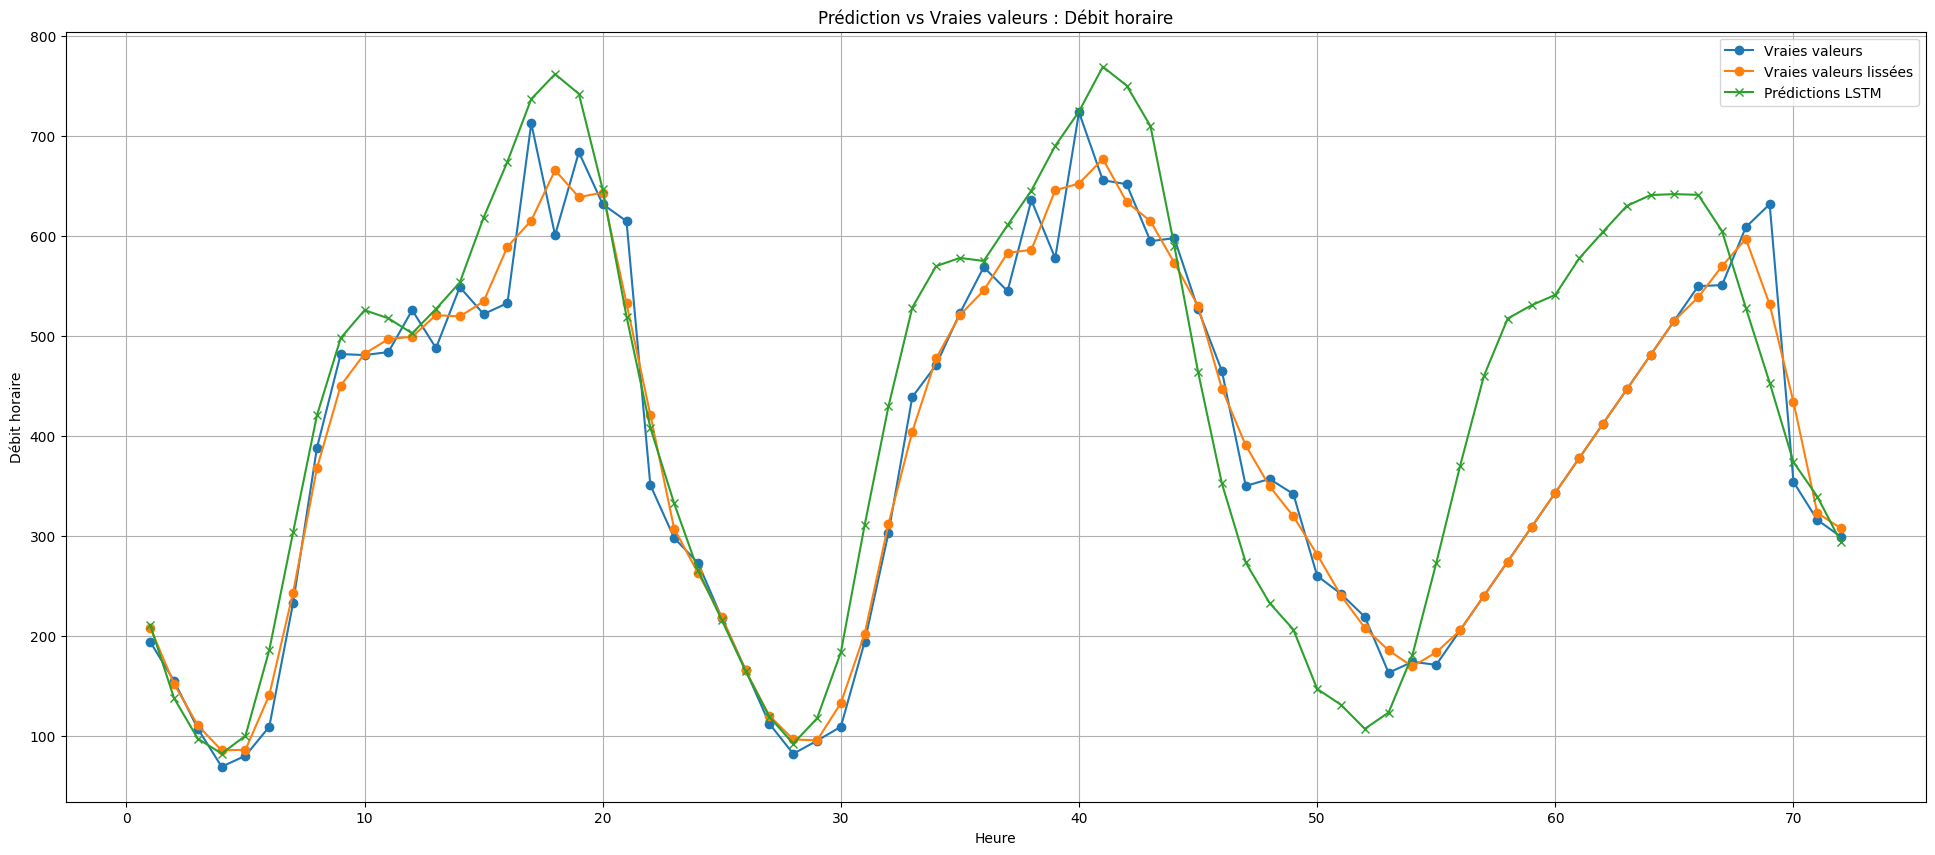

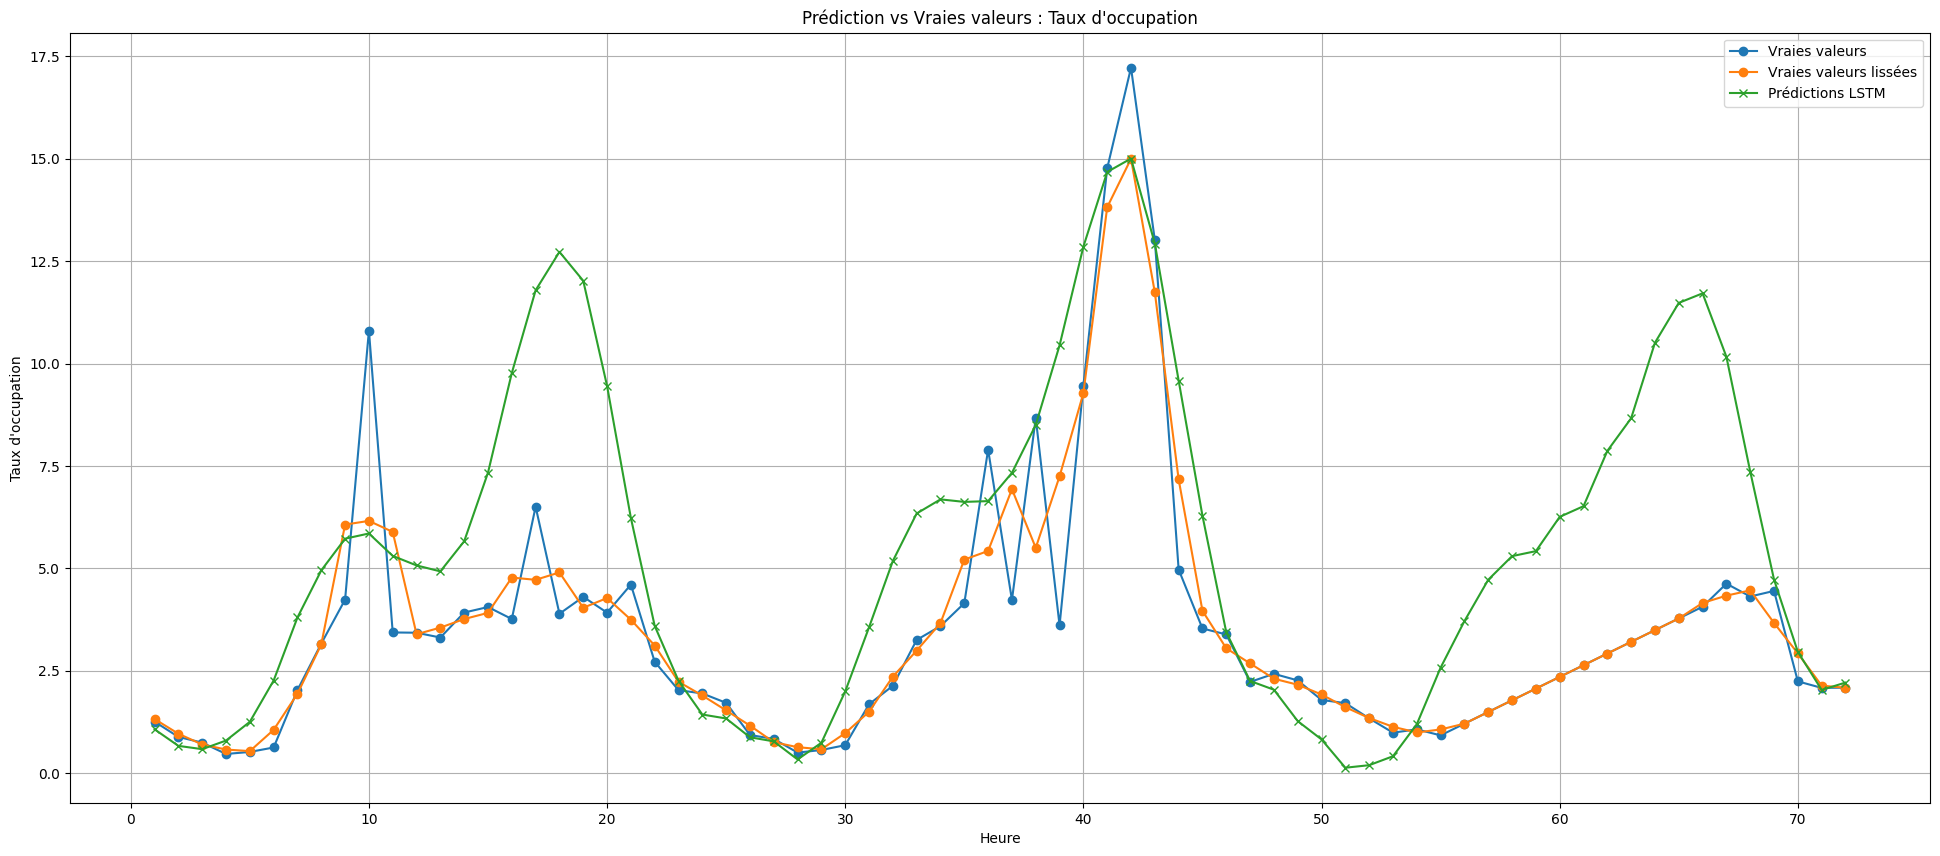

In [ ]:
hours = np.arange(1, 73)
for i, target in enumerate(targets):
    plt.figure(figsize=(24,10))
    plt.plot(hours, df_champs_orig_last[targets[i]].values, marker='o', label='Vraies valeurs')
    plt.plot(hours, final_eval_df[targets[i]].values, marker='o', label='Vraies valeurs lissées')
    plt.plot(hours, y_pred[:, i], marker='x', label='Prédictions LSTM')
    plt.title(f'Prédiction vs Vraies valeurs : {target}')
    plt.xlabel('Heure')
    plt.ylabel(target)
    plt.grid(True)
    plt.legend()
    plt.show()